#BASIC IMPORTS

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models
from torch import optim
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from io import open
import os,string,random
from torch.utils.data import Dataset

#DATA PREPROCESSING

We will add the segmentation part at a later stage as it alone will require an object detection network. It will make the network more robust.

Data Augmentation
1. Image Resizing
2. Image Flipping
3. Add noise
4. Blur img
5. Normalization

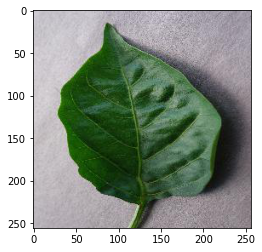

In [56]:
image = Image.open('IMG.JPG')
plt.imshow(image)

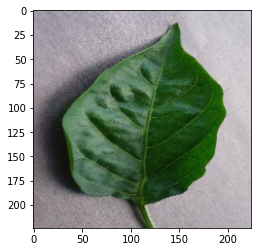

In [58]:
im = image_transform(image)
im_np = np.array(im,dtype=np.float64)
im_np = (im_np*0.5)+0.5
plt.imshow(np.transpose(im_np,(1,2,0)))

In [11]:
class PlantImageDataloader(Dataset):

    def __init__(self,filename,transform,plant_name="TOMATO"):
        self.images_dict = self.read_dataset(filename,transform)        #a dictionary containing image all the images with key=crop name
                                                                        #the values are of the form [image,disease] 
        self.p_name = plant_name                                        #plant(crop) name as a member variable                                            
        self.n = self.__len__(plant_name)                               #number of datapoints for the plant
        self.shuffle_indices = list(range(self.n))                      #indices shuffled to get a random sample
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self,plant_name="TOMATO"):
        return len(self.images_dict[plant_name])                        #return the length of the dataset

    def __getitem__(self,idx,plant_name="TOMATO"):
        return self.images_dict[plant_name][idx]                        #get a datapoint with a specific index and plant name
    
    def read_dataset(self,filename,img_transform):                      #function to read the data
        dataset_dict = {}
        try:
            for image_folder in os.listdir(filename):                   #iterate through the different folders
                plant_name = self.getPlantName(image_folder)            #get the plant name from the function
                folders_path = f"{filename}/{image_folder}"             
                images_list = []
                print("[INFO] Reading the folder",image_folder)         
                i=0
                for image_name in os.listdir(f"{filename}/{image_folder}"):     #iterate through the images
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                       #read image in PIL format

                    disease_name = self.getDiseaseName(image_name)              #get the disease name from the filename of the img

                    current_image = img_transform(current_image)                #transform the image (resize,flip,tensor,normalize)

                    images_list.append([current_image,disease_name])            #append the image and the disease name to a list
                    if i%100==0:
                        print("Read ",i," images in ",image_folder,"folder")        
                    
                if plant_name not in dataset_dict.keys():
                    dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                else:
                    dataset_dict[plant_name].extend(images_list)
        except Exception as e:
            print(f"Error : {e}")
            
        return dataset_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        i = np.random.randint(self.n) #len(self.images_dict[plant_name]))
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        plant = name[0:name.find('_')].upper()                  #processing the file name to get the plant(crop) name
        return plant
        
    def getDiseaseName(self,name):
        sec_last_pos = name[:name.rfind("_")].rfind("_")        #gets the second last position of _
        tempname = name[sec_last_pos:]                          #get the disease name from the end
        disname = ""
        for sub in tempname.split('_'):                         #processing
            disname+= (sub.upper()+" ")
        disname = disname.strip()
        return disname

    def get_batch_from_array(self,batch_size,array):            #a helper function to get a batched input
        end = self.shuffle_start_index + batch_size
        batch = []

        if end>=self.n:
            batch = [array[i] for i in self.shuffle_indices[0:(end%self.n)]]
            end = self.n
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",post_process=True):       #funtion to get a batched input in which the datapoints are plant data
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name])
        self.shuffle_start_index += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index>=self.n:
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
        return img_batch          
    


1. The image is resize to make it fit to be an input to the resnet model
2. The data is normalized in the transforms so that all the images have the same distribution in the pixels and hence the model converges faster


In [12]:
image_transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.RandomHorizontalFlip(p=0.6),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [13]:
#path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
#path = f"drive/My Drive/PlantVillage"
path = f"drive/My Drive/PlantVillage2"
train_data = PlantImageDataloader(path,image_transform)

[INFO] Reading the folder Tomato_Target_Spot
Read  100  images in  Tomato_Target_Spot folder
[INFO] Reading the folder Pepper__bell___Bacterial_spot
Read  100  images in  Pepper__bell___Bacterial_spot folder


One Hot Vectors for data

In [ ]:
def get_oneHotVector(data_list):
    #This function expects a list of the form [image,disease]
    labels = []
    imgs = 
    for (img,label) in data_list:
        labels.append(label)


#DATA VISUALIZATION

In [7]:
a=np.array([])
a=np.append(a,'a')
a

array(['a'], dtype='<U32')

In [26]:
class PlantImageDataloader2(Dataset):

    def __init__(self,filename,transform,plant_name="TOMATO"):
        self.images_dict,self.labels_dict = self.read_dataset(filename,transform)        #a dictionary containing image all the images with key=crop name
                                                                        #the values are of the form [image,disease] 
        self.p_name = plant_name                                        #plant(crop) name as a member variable                                            
        self.n = self.__len__(plant_name)                               #number of datapoints for the plant
        self.shuffle_indices = list(range(self.n))                      #indices shuffled to get a random sample
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self,plant_name="TOMATO"):
        return len(self.images_dict[plant_name])                        #return the length of the dataset

    def __getitem__(self,idx,plant_name="TOMATO"):
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        #get a datapoint with a specific index and plant name
    
    def read_dataset(self,filename,img_transform):                      #function to read the data
        dataset_dict = {}
        labels_dict = {}
        try:
            for image_folder in os.listdir(filename):                   #iterate through the different folders
                plant_name = self.getPlantName(image_folder)            #get the plant name from the function
                disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
                folders_path = f"{filename}/{image_folder}"             
                images_list = []
                labels_list=[]
                print("[INFO] Reading the folder",image_folder)         
                i=0
                for image_name in os.listdir(f"{filename}/{image_folder}"):     #iterate through the images
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                       #read image in PIL format

                    current_image = img_transform(current_image)                #transform the image (resize,flip,tensor,normalize)

                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%100==0:
                        print("Read ",i," images in ",image_folder,"folder")        
                    
                if plant_name not in dataset_dict.keys():
                    dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                    labels_dict[plant_name] = labels_list
                else:
                    dataset_dict[plant_name].extend(images_list)
                    labels_dict[plant_name].extend(labels_list)
                    
        except Exception as e:
            print(f"Error : {e}")
            
        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        i = np.random.randint(self.n) #len(self.images_dict[plant_name]))
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        plant = name[0:name.find('_')].upper()                  #processing the file name to get the plant(crop) name
        return plant
        
    def getDiseaseName(self,name):
        sec_last_pos = name[:name.rfind("_")].rfind("_")        #gets the second last position of _
        tempname = name[sec_last_pos:]                          #get the disease name from the end
        disname = ""
        for sub in tempname.split('_'):                         #processing
            disname+= (sub.upper()+" ")
        disname = disname.strip()
        return disname

    def get_batch_from_array(self,batch_size,array):            #a helper function to get a batched input
        end = self.shuffle_start_index + batch_size
        batch = []

        if end>=self.n:
            batch = [array[i] for i in self.shuffle_indices[0:(end%self.n)]]
            end = self.n
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",post_process=True):       #funtion to get a batched input in which the datapoints are plant data
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name])
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name])
        self.shuffle_start_index += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index>=self.n:
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
        return img_batch,label_batch          
    


In [38]:
path = f"drive/My Drive/PlantVillage2"
train_data = PlantImageDataloader2(path,image_transform)

[INFO] Reading the folder Pepper__bell___Bacterial_spot
[INFO] Reading the folder Potato___Early_blight
[INFO] Reading the folder Pepper__bell___healthy
[INFO] Reading the folder Tomato__Tomato_YellowLeaf__Curl_Virus
[INFO] Reading the folder Tomato__Tomato_mosaic_virus
[INFO] Reading the folder Tomato__Target_Spot
[INFO] Reading the folder Tomato_Septoria_leaf_spot
[INFO] Reading the folder Potato___Late_blight
[INFO] Reading the folder Potato___healthy
[INFO] Reading the folder Tomato_Spider_mites_Two_spotted_spider_mite
[INFO] Reading the folder Tomato_Bacterial_spot
[INFO] Reading the folder Tomato_Leaf_Mold
[INFO] Reading the folder Tomato_Late_blight
[INFO] Reading the folder Tomato__healthy
[INFO] Reading the folder Tomato_Early_blight


In [44]:
imgs,labs = train_data.get_batch(1,"TOMATO")
print(imgs)

[tensor([[[ 0.0510, -0.1765, -0.1216,  ..., -0.0745, -0.0196, -0.1059],
         [-0.1529, -0.0196, -0.0510,  ..., -0.0431, -0.1059, -0.1216],
         [-0.1059, -0.1451, -0.1216,  ...,  0.0039, -0.1294, -0.2314],
         ...,
         [ 0.3725,  0.3255,  0.3647,  ...,  0.5529,  0.5137,  0.4902],
         [ 0.3647,  0.3412,  0.3098,  ...,  0.5843,  0.4980,  0.5059],
         [ 0.3412,  0.3882,  0.2784,  ...,  0.5922,  0.5294,  0.6000]],

        [[-0.0902, -0.3176, -0.2627,  ..., -0.2314, -0.1765, -0.2627],
         [-0.2941, -0.1608, -0.1922,  ..., -0.2000, -0.2627, -0.2784],
         [-0.2471, -0.2863, -0.2627,  ..., -0.1529, -0.2863, -0.3882],
         ...,
         [ 0.2784,  0.2314,  0.2706,  ...,  0.4667,  0.4275,  0.4039],
         [ 0.2706,  0.2471,  0.2157,  ...,  0.4980,  0.4118,  0.4196],
         [ 0.2471,  0.2941,  0.1843,  ...,  0.5059,  0.4431,  0.5137]],

        [[ 0.0039, -0.2235, -0.1686,  ..., -0.1608, -0.1059, -0.1922],
         [-0.2000, -0.0667, -0.0980,  ..., -

In [45]:
print(labs)

['TARGET SPOT']


In [55]:
def print_image(img_tensor,axis="off"):
    img_numpy = img_tensor.numpy()                  #convert the tensor back to nummpy array
    img_numpy = img_numpy*0.5 + 0.5                 #un-normalize the array
    img_numpy = np.transpose(img_numpy,(1,2,0))     #(channels,height,width)->(height,width,channels)
    plt.imshow(img_numpy)
    plt.axis(axis)
    plt.show()

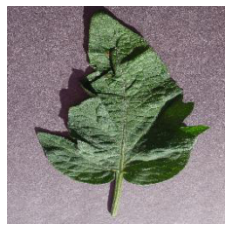

In [54]:
print_image(imgs[0])